In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import cv2,os

# download the resnet50 model

In [8]:
resnet = tf.keras.applications.ResNet50()

102967424/102967424 [==============================] - 5s 0us/step


In [9]:
resnet.input_shape

(None, 224, 224, 3)

In [10]:
resnet.output_shape

(None, 1000)

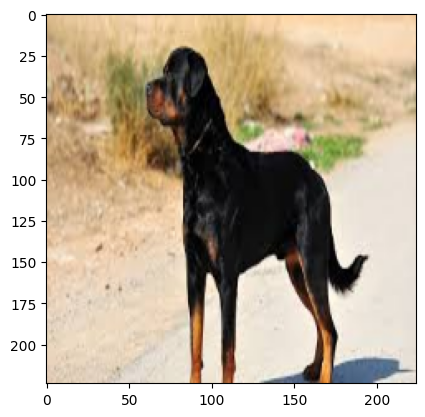

In [32]:
image = cv2.imread('/content/images.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
plt.imshow(image)
plt.show()

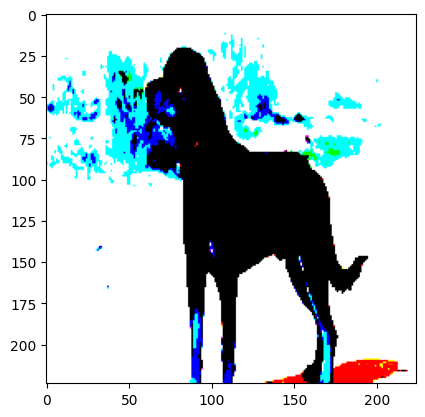

In [33]:
image = tf.keras.applications.resnet50.preprocess_input(image)
plt.imshow(image)
plt.show()

In [34]:
image.shape

(224, 224, 3)

In [35]:
image = np.expand_dims(image,axis=0)
image.shape

(1, 224, 224, 3)

In [36]:
result = resnet.predict(image)

1/1 [==============================] - 0s 25ms/step


In [37]:
np.argmax(result)

165

In [38]:
tf.keras.applications.resnet50.decode_predictions(result)

[[('n02089078', 'black-and-tan_coonhound', 0.648381),
  ('n02101006', 'Gordon_setter', 0.34936258),
  ('n02107142', 'Doberman', 0.0012562978),
  ('n02106550', 'Rottweiler', 0.0005491814),
  ('n02088466', 'bloodhound', 0.00025877275)]]

# Models without top layer

In [ ]:
resnet_no_top_layer = tf.keras.applications.ResNet50(include_top=False,input_shape=(224,224,3))

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
resnet_no_top_layer.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

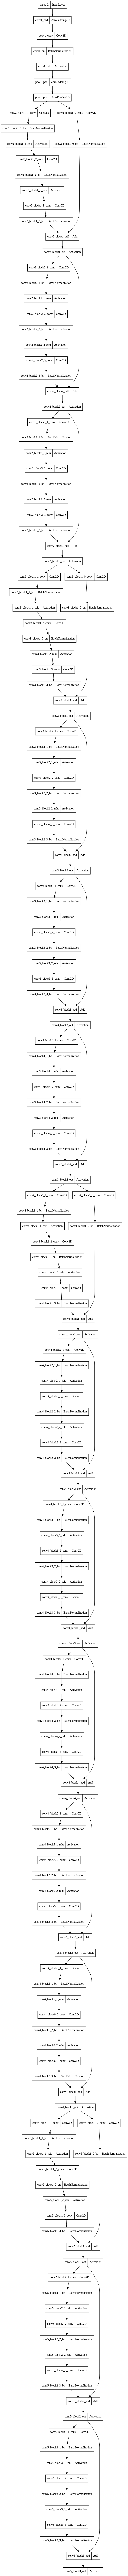

In [ ]:
tf.keras.utils.plot_model(resnet_no_top_layer)

# Importing kaggle and dog breed identification 

In [ ]:
import kaggle

OSError: ignored

In [ ]:
! mv kaggle.json /root/.kaggle

In [ ]:
import kaggle

In [ ]:
! kaggle competitions download -c dog-breed-identification

100% 688M/691M [00:17<00:00, 42.7MB/s]
100% 691M/691M [00:17<00:00, 40.9MB/s]


In [ ]:
! unzip -q dog-breed-identification.zip

In [ ]:
label = pd.read_csv('labels.csv')

In [ ]:
label['filename'] = label['id'] + '.jpg'

In [ ]:
label.head()

,id,breed,filename
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg


In [ ]:
batch_size =64 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
idg = ImageDataGenerator(validation_split=0.1,rotation_range=0.3,horizontal_flip=True)

In [ ]:
train_idg = idg.flow_from_dataframe(label,directory='train/',x_col='filename',y_col='breed',
target_size=(224,224),batch_size=batch_size,subset='training')

Found 9200 validated image filenames belonging to 120 classes.


In [ ]:
val_idg = idg.flow_from_dataframe(label,directory='train/',x_col='filename',y_col='breed',
target_size=(224,224),batch_size=batch_size,subset='validation')

Found 1022 validated image filenames belonging to 120 classes.


# Model (VGG16 + Resnet50)

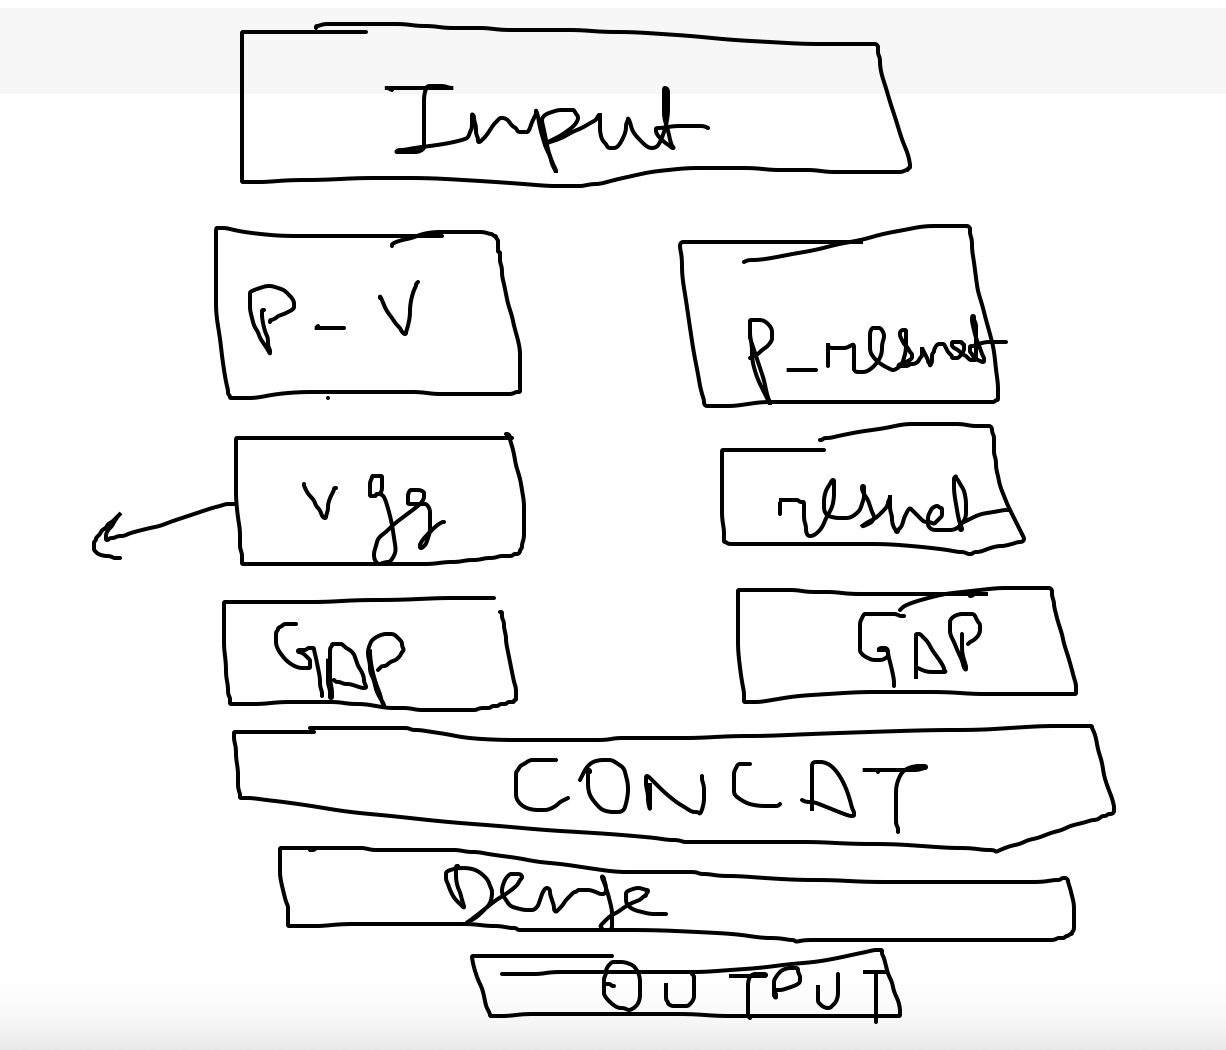

In [ ]:
# Input Layer 
input = tf.keras.layers.Input(shape=(224,224,3),name ='InputLayer')

#VGG 
# Preprocessing layer 
vgg_pre_process = tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input,name='VGGPreprocess') (input)

# Download the model(VGG16)
vgg_model = tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3))
vgg_model.trainable = False

# VGG layer
vgg = vgg_model(vgg_pre_process)

# Gloabal Average pooling layer
vgg_avg = tf.keras.layers.GlobalAveragePooling2D(name='VGGGlobalAvgPool') (vgg)

#Resnet
# Preprocessing layer 
resnet_pre_process = tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input,name='ResnetPreprocess') (input)

# Download the model(resnet50)
resnet_model = tf.keras.applications.ResNet50(include_top=False,input_shape=(224,224,3))
resnet_model.trainable = False

# resnet layer
resnet = resnet_model(vgg_pre_process)

# Gloabal Average pooling layer
resnet_avg = tf.keras.layers.GlobalAveragePooling2D(name='ResnetGlobalAvgPool') (resnet)

# FCNN (CAT Layers)
# Concat vgg_avg and resnet_avg layers
concat = tf.keras.layers.Concatenate(name='concatlayer') ([vgg_avg,resnet_avg])
dropout = tf.keras.layers.Dropout(0.5,name='dropout')(concat)
dense = tf.keras.layers.Dense(256,activation='relu',name='Dense')(dropout)
output  = tf.keras.layers.Dense(120,activation='softmax',name='outputLayer')(dense)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
final_model = tf.keras.models.Model(inputs=[input],outputs=[output])

In [ ]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGGPreprocess (Lambda)         (None, 224, 224, 3)  0           ['InputLayer[0][0]']             
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['VGGPreprocess[0][0]']          
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['VGGPreprocess[0][0]']      

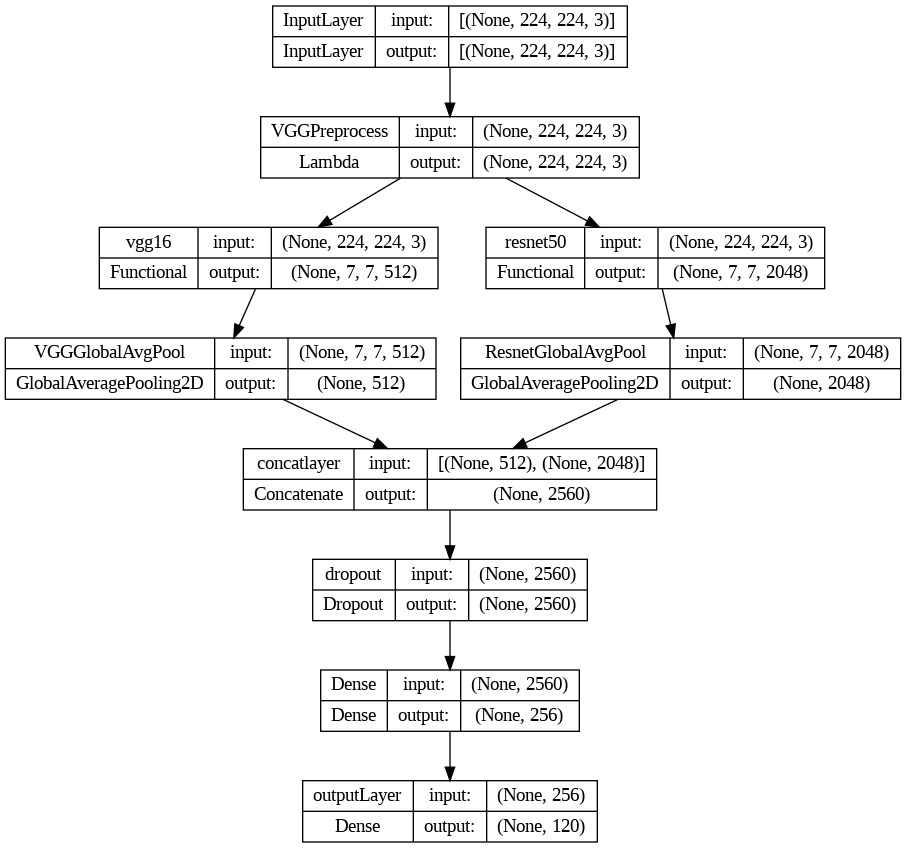

In [ ]:
tf.keras.utils.plot_model(final_model, show_shapes=True)

In [ ]:
final_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss = tf.keras.losses.categorical_crossentropy, 
                    metrics = ["acc"])

In [ ]:
hist = final_model.fit(train_idg, batch_size = batch_size, epochs = 10, validation_data=val_idg)

Epoch 1/10
144/144 [==============================] - 166s 1s/step - loss: 1.6828 - acc: 0.5320 - val_loss: 1.2046 - val_acc: 0.6282
Epoch 2/10
144/144 [==============================] - 157s 1s/step - loss: 1.3378 - acc: 0.6097 - val_loss: 1.1286 - val_acc: 0.6673
Epoch 3/10
144/144 [==============================] - 160s 1s/step - loss: 1.1848 - acc: 0.6529 - val_loss: 1.0207 - val_acc: 0.6849
Epoch 4/10
144/144 [==============================] - 161s 1s/step - loss: 1.0274 - acc: 0.6904 - val_loss: 1.0016 - val_acc: 0.6898
Epoch 5/10
144/144 [==============================] - 158s 1s/step - loss: 0.9412 - acc: 0.7170 - val_loss: 1.0764 - val_acc: 0.6918
Epoch 6/10
144/144 [==============================] - 154s 1s/step - loss: 0.8772 - acc: 0.7398 - val_loss: 1.0414 - val_acc: 0.7035
Epoch 7/10
144/144 [==============================] - 158s 1s/step - loss: 0.8182 - acc: 0.7499 - val_loss: 1.0113 - val_acc: 0.7104
Epoch 8/10
144/144 [==============================] - 157s 1s/step - 

In [ ]:
final_model.save('/content/drive/MyDrive/Resnet50')

In [ ]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

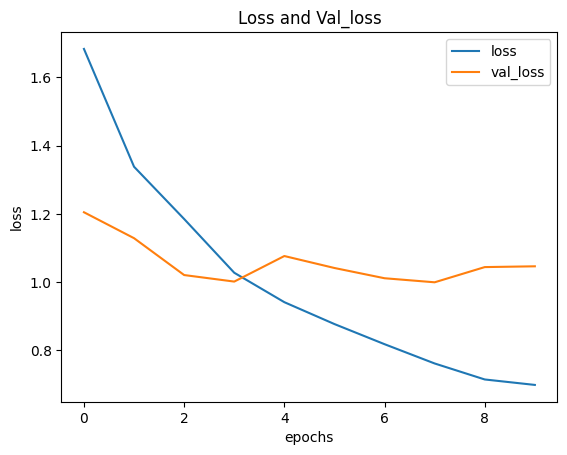

In [ ]:
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.title('Loss and Val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


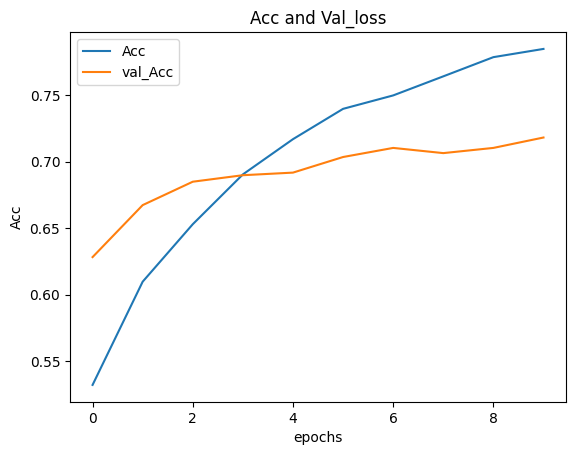

In [ ]:
plt.plot(hist.history['acc'],label='Acc')
plt.plot(hist.history['val_acc'],label='val_Acc')
plt.title('Acc and Val_loss')
plt.xlabel('epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()